<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II

In this session, we will focus on how to uncover long timescale properties of complex dynamical systems through a transfer operator approach.

Before we start, load the following python packages:

In [1]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

In [2]:
import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

/content/DPG_PhysicsBehavior_2026
Already up to date.
/content
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35


In [15]:
import h5py
import numpy as np
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

## Stochastic dynamics on a 1d double well

We will start by a simple example, for which the long-lived dynamics can be derived analytically.

We will be considering overdamped Langevin dynamics on a potential landscape,

$$
\dot{x}(t) = -\partial_x V(x) + \sqrt{2 T_x}\,\eta(t),
\qquad \langle \eta(t)\eta(t') \rangle = \delta(t-t').
$$

Where the potential landscape is given by of a double well type:

$$
V(x) = \frac{x^4}{4} -\mu \frac{x^2}{2}
$$

Changing the sign of $\mu$ pushes the dynamics through a pitchfork bifurcation. You can check that yourself by finding the fixed points of the dynamics and their stability.

Let's gain intuition by making some simulations using a simpler Euler scheme


In [91]:
from numba import jit,prange
@jit(nopython=True, parallel=True)
def simulate_dw(x0s,mu_vals, tau_x, Tx, dt, max_iters,downsampling):
    n_sims = len(x0s)
    sims = np.zeros((n_sims, int(max_iters/downsampling)))
    for ks in prange(n_sims):
        mu=mu_vals[ks]
        x0 = x0s[ks]
        x = x0
        for i in range(max_iters):
            new_x = x + (-x**3+mu*x) * dt/tau_x + np.sqrt(2 * Tx*(1/tau_x)) * np.random.normal(0, np.sqrt(dt))
            x = new_x
            if i%downsampling==0:
                sims[ks, int(i/downsampling)] = x
    return sims

In [92]:
n_sims = 3
x0s = np.random.uniform(-1,1,n_sims)

mu_vals = [-.5,.5,1.]

Tx=2.5e-1
tau_x=1
T = 50000
dt=5e-3
max_iters=int(T/dt)
final_dt = 1e-1
downsampling = int(final_dt/dt)
sims = simulate_dw(x0s,mu_vals, tau_x, Tx, dt, max_iters,downsampling)

As you can see, depending on the value of $\mu$ the macroscopic properties of the dynamics change. When $\mu > 0$ we see two stable fixed points which traps the dynamics on a long timescale

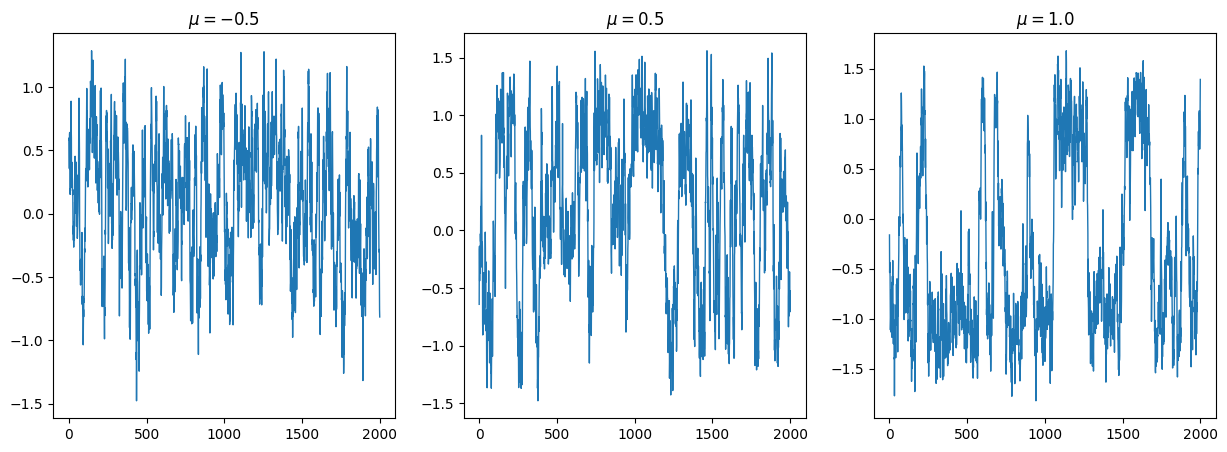

In [126]:
plt.figure(figsize=(15,5))
for k in range(n_sims):
  plt.subplot(1,3,k+1)
  plt.title(r'$\mu = {:.1f}$'.format(mu_vals[k]))
  plt.plot(sims[k][:2000],lw=1)
plt.show()

At large times, the system relaxes to the steady-state distribution, which in our case is given by the Boltzmann distrituion.

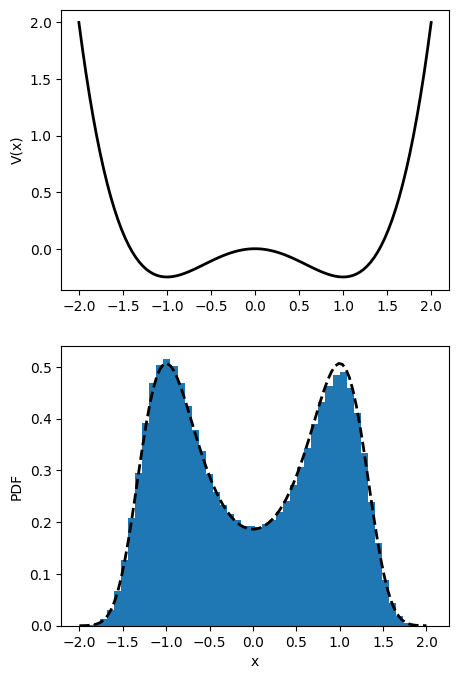

In [127]:
def potential(x,mu):
    return x**4 / 4 - mu * x**2 / 2

sim_idx=2
mu = mu_vals[sim_idx]
x = np.linspace(-2,2,100)
plt.figure(figsize=(5,8))
plt.subplot(2,1,1)
plt.plot(x,potential(x,mu),lw=2,c='k')
plt.ylabel('V(x)')
pB = np.exp(-potential(x,mu)/Tx)
Z = np.trapezoid(pB,x)
pB =pB/Z
plt.subplot(2,1,2)
plt.hist(sims[sim_idx],bins=50,density=True,label='sim')
plt.plot(x,pB,c='k',ls='--',lw=2,label='pB')
plt.xlabel('x')
plt.ylabel('PDF')
plt.show()

We can calculate this integral numerically, or approximate it analytically in the asymptotic limit

In [106]:
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid

def exppot(x, Tx,mu,sign=-1, fun=lambda z: 1):
    return np.exp(sign*potential(x,mu)/Tx)*fun(x)

def omega_be(Tx,mu,c):
    z = np.linspace(-20, 0, 1000)
    iarr = cumulative_trapezoid(exppot(z,Tx,mu), z, initial=0)
    ifun = interp1d(z, iarr)

    y = np.linspace(-1, 0, 1000)
    oarr = cumulative_trapezoid(exppot(y,Tx,mu, sign=1, fun=ifun), y, initial=0)/Tx
    ofun = interp1d(y, oarr)

    return 1/(2*ofun(0))

In [104]:
sim_idx=2
1/omega_be(Tx,mu_c_vals[sim_idx][0],mu_c_vals[sim_idx][1])

np.float64(16.290370941299432)

# Extracting slow modes through a transfer operator picture of the dynamics

As we've seen above, in this simple case most properties of the dynamics can be directly evaluated analytically. However, in many complex systems (as we'll see below), the long-lived properties of the dynamics are not immediately apparent from the equations, and analytical solutions are challenging to obtain.

To access the long-lived properties of the dynamics more directly, we will make use of an equivalent representation of the dynamics in terms of a transfer operator for the evolution of probability distributions in the state space.

From the above Langevin dynamics, we can write the Fokker-Planck equation for the density $\rho$ dynamics,

$$
\dot{\rho}(t) = \partial_x\left(\partial_x V(x) \rho(t) \right) + T_x\partial_x^2 \rho(t),
$$

which we can rewrite as,

$$
\dot{\rho}(t) = L \rho(t)
$$

where $L = \partial_x\left(\partial_x V(x) \cdot \right) + T_x\partial_x^2\cdot$, is the forward Fokker-Planck operator, a linear operator that determines the evolution of probability distributions in the state space driven by the nonlinear Langevin dynamics encoded in $V(x)$.

## Finite-difference estimator of the transfer operator

We can numerically approximate $L$ through a finite-difference estimator. Here, we will make use of the Chang-Cooper method (Change, Cooper. *A Practical Difference Scheme for Fokker-Planck Equations*. J. Comput. Physics 1969)

In [173]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla


def fokker_planck_L_sg(x, mu, Tx, tau_x=1.0, boundary="reflecting",potential=None):
    """
    Build L for ∂_t p = ∂_x(∂_x V p) + Tx ∂_x^2 p on a uniform grid x (Chang-Cooper).
    Pass exactly one of:
      - potential(x): callable returning V(x)
    """
    x = np.asarray(x); N = x.size
    dx = x[1] - x[0]; D = Tx

    # Bernoulli function
    def B(z):
        out = np.empty_like(z)
        small = np.abs(z) < 1e-8
        out[~small] = z[~small] / np.expm1(z[~small])
        zS = z[small]
        out[small] = 1 - zS/2 + zS**2/12
        return out

    V = potential(x,mu)
    dV_face = V[1:] - V[:-1]
    psi = -(dV_face) / D

    a = (D / dx**2) * B(psi)      # coeff to node i+1 from face i+1/2
    b = (D / dx**2) * B(-psi)     # coeff to node i   from face i+1/2

    diag  = np.zeros(N)
    upper = np.zeros(N-1)
    lower = np.zeros(N-1)

    # interior
    diag[1:-1]  = -(b[1:] + a[:-1])
    upper[1:-1] =  a[1:-1]
    lower[0:-1] =  b[0:-1]

    if boundary == "reflecting":
        diag[0]   = -b[0];   upper[0]  =  a[0]
        diag[-1]  = -a[-1];  lower[-1] =  b[-1]; upper[-1] =  a[-1]
    elif boundary == "absorbing":
        diag[0] = upper[0] = 0.0
        diag[-1] = lower[-1] = 0.0
        lower[0] = 0.0
        upper[-1] = 0.0
    else:
        raise ValueError("boundary must be 'reflecting' or 'absorbing'")

    L = sp.diags([lower, diag, upper], offsets=[-1,0,1], format="csc")
    return (1.0/tau_x)*L

In [228]:
N = 1000

mu=1.
x_min, x_max = -np.sqrt(np.abs(mu))-4*np.sqrt(Tx),np.sqrt(np.abs(mu))+4*np.sqrt(Tx)
x = np.linspace(x_min, x_max, N)
tau_x=1
delay=1e-1
V = lambda x,mu: x**4 / 4 - mu * x**2 / 2

L_fp = fokker_planck_L_sg(x,mu,Tx,tau_x,potential=V)

Now we can directly simulate the dynamics of the entire probability distribution function, rather than a single trajectory. For example, starting from a delta function, we can evolve the dynamics by taking,

$$
\rho(t+\tau) = P_\tau \rho(t),
$$

where $P_\tau = e^{L \tau}$ is the discrete time transition matrix, also known as the forward propagator.



In [229]:
print('Obtain transition matrix')
P_tau = spla.expm(delay * L_fp)

print('Iterate probability distribution function')
p0 = np.zeros(P_tau.shape[0]) # set initial condition as a delta function
p0[200] = 1
n_iters=100
p=p0
ps=np.zeros((n_iters,p.shape[0]))
ps[0]=p
for k in range(1,n_iters): #iterate the dynamics
    p = P_tau @ p
    ps[k]=p

Obtain transition matrix
Iterate probability distribution function


You can now observe the relaxation of the probability distribution to the steady state, which we now is given by the Boltzmann distribution

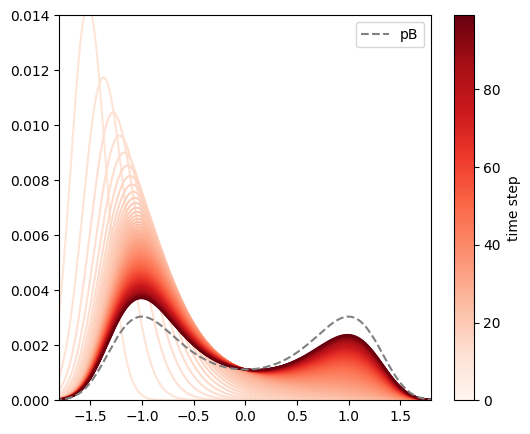

In [230]:
import matplotlib as mpl

ds = 1
n = int(len(ps)/ds)
colors_c = plt.cm.Reds(np.linspace(0.1, 1, n))

plt.figure(figsize=(6,5))
for k, k_ in enumerate(np.arange(1, len(ps), ds)):
    p = ps[k_]
    plt.plot(x, p, c=colors_c[k])

plt.xlim(-1.8, 1.8)
plt.ylim(0, 0.014)

norm = mpl.colors.Normalize(vmin=0, vmax=n-1)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])

ax = plt.gca()
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("time step")
pB = np.exp(-V(x,mu)/Tx)
pB = pB/np.sum(pB)
plt.plot(x,pB,c='gray',ls='--',label='pB')
plt.legend()
plt.show()


In [172]:
## For an animation uncomment this code

# import matplotlib.animation as animation
# from IPython.display import HTML
# import matplotlib as mpl

# ds = 1
# frames = np.arange(1, len(ps), ds)

# fig, ax = plt.subplots(figsize=(6,5))

# line, = ax.plot([], [], lw=2)
# line_B, = ax.plot([], [], c='gray', ls='--', label='pB')

# ax.set_xlim(-1.8, 1.8)
# ax.set_ylim(0, 0.014)
# ax.set_xlabel("x")
# ax.set_ylabel("p(x,t)")

# # Boltzmann reference
# pB = np.exp(-V(x,mu)/Tx)
# pB = pB / np.sum(pB)
# line_B.set_data(x, pB)

# # Color map
# cmap = plt.cm.Reds
# norm = mpl.colors.Normalize(vmin=0, vmax=len(frames))

# def init():
#     line.set_data([], [])
#     return line, line_B

# def animate(i):
#     p = ps[frames[i]]
#     line.set_data(x, p)
#     line.set_color(cmap(norm(i)))
#     ax.set_title(f"time step = {frames[i]}")
#     return line, line_B

# ani = animation.FuncAnimation(
#     fig, animate, init_func=init,
#     frames=len(frames), interval=30, blit=True
# )

# plt.close(fig)

# HTML(ani.to_jshtml())


## Decomposing the dynamics into it's long-lived modes

The Fokker-Planck operator, as well as it's discrete time propagator, share important eigenvalue and eigenvector properties. In particular, the eigenvalues of $L$, $\Lambda_k$ are related to those of $P_\tau$, $\lambda_k$. Indeed, since $P_\tau = e^{L \tau}$ the eigenvalue decomposition yields,

$P_\tau \psi_k = \lambda_k \psi_k = e^{\Lambda_k \tau} \psi_k$, and so $\lambda_k = e^{\Lambda_k \tau}$.


$P_\tau$ always has an eigenvector of eigenvalue 1, which corresponds to the steady-state distribution since it's unchanged when acted by $P_\tau$,

$P_\tau \pi = \pi$. Let's see what that looks like

In [231]:
eigvals_fwd,eigvecs_fwd = op_calc.sorted_spectrum(P_tau,k=5)
pi = eigvecs_fwd[:,0].real/eigvecs_fwd[:,0].real.sum()

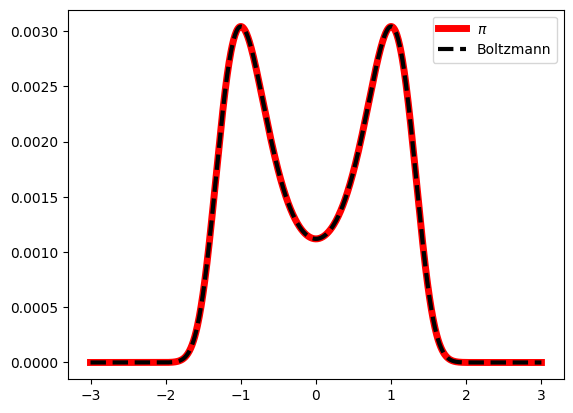

In [232]:
plt.plot(x,pi,c='r',lw=5,label=r'$\pi$')
plt.plot(x,pB,c='k',ls='--',lw=3,label='Boltzmann')
plt.legend()
plt.show()

So the first right eigenvector of $P_\tau$ corresponds to the steady-state distribution. The remaining eigenvectors decay to the steady-state distribution on a timescale given by

$$
\Lambda^{-1}_k = -\frac{\tau}{\log \lambda_k}.
$$


The time it takes to transition from one well to another can be obtained analytically through the theory of first passage times (see e.g. Pavliotis *Stochastic Processes and Applications* 2014)

Let's consider that the particle starts at a minimum of the potential well $x_0=a$ and escapes when reaching the barrier situated at $x_f = b$. Assuming reflective boundary conditions at $x_0=a$ and an absorbing boundary at $x_f=b$ (where the escape events occurs), we have,

$$
\overline{\tau}(x_0) = \frac{1}{\tau_x T_x} \int_{x_0}^b e^{V(y)/T_x}dy \int_a^y  e^{-\beta V(z)/T_x} dz.
$$



In [251]:
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid

def exppot(x, Tx,mu,sign=-1, fun=lambda z: 1):
    return np.exp(sign*potential(x,mu)/Tx)*fun(x)

def omega_be(Tx,mu):
    z = np.linspace(-20, 0, 5000)
    iarr = cumulative_trapezoid(exppot(z,Tx,mu), z, initial=0)
    ifun = interp1d(z, iarr)

    y = np.linspace(-1, 0, 5000)
    oarr = cumulative_trapezoid(exppot(y,Tx,mu, sign=1, fun=ifun), y, initial=0)/Tx
    ofun = interp1d(y, oarr)

    return 1/(ofun(0))

In [252]:
1/omega_be(Tx,mu)

np.float64(5.743426410479272)

In [253]:
-delay/np.log(eigvals_fwd[1])

np.complex128(5.342709032300366-0j)

In [ ]:
sim_idx=2
1/omega_be(Tx,mu)

In [199]:
_,eigvecs_bw = op_calc.sorted_spectrum(P_tau.T,k=5)

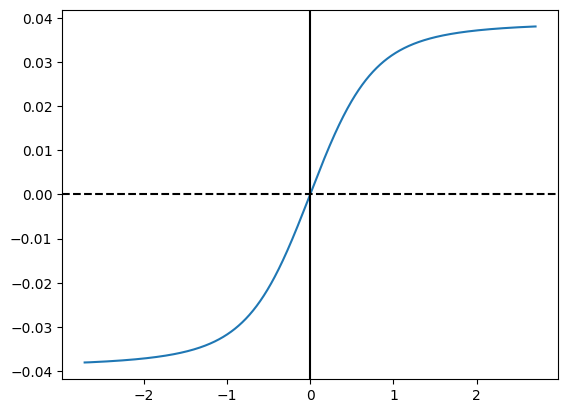

In [200]:
plt.plot(x,eigvecs[:,1].real)
plt.axvline(0,c='k')
plt.axhline(0,c='k',ls='--')
plt.show()

In [12]:
from scipy.integrate import odeint

def Lorenz(state,t,sigma,rho,beta):
    # unpack the state vector
    x,y,z = state
    # compute state derivatives
    xd = sigma * (y-x)
    yd = (rho-z)*x - y
    zd = x*y - beta*z
    # return the state derivatives
    return [xd, yd, zd]

dt = 0.02
frameRate=1/dt
T = 2000
discard_T = 500
T_total = T+discard_T
state0 = np.array([-8, -8, 27])
t = np.linspace(0, T_total, int(T_total*frameRate))
sigma,rho,beta=10,28,8/3
tseries=np.array(odeint(Lorenz,state0,t,args=(sigma,rho,beta)),dtype=np.float64)[int(discard_T/dt):]

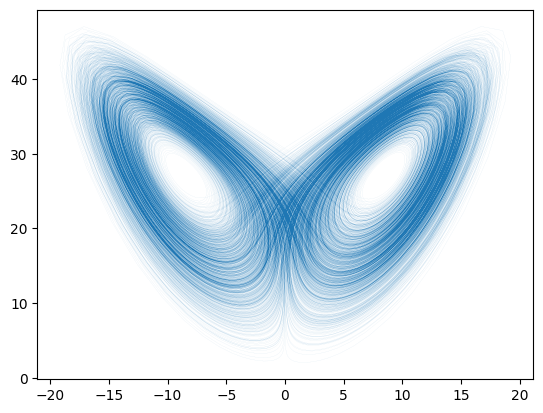

In [19]:
plt.plot(tseries[:,0],tseries[:,2],lw=.02)
plt.show()